# Exploring BPZ Test Data

_Alex Malz (NYU) & Phil Marshall (SLAC)_

In this notebook we develop machinery to evaluate our approximations on whole datasets in "survey mode." 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import print_function
    
import hickle
import numpy as np
from pathos.multiprocessing import ProcessingPool as Pool
import random
import cProfile
import pstats
import StringIO
import timeit
import psutil
import sys
import os
import timeit

import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
%matplotlib inline

import qp
from qp.utils import calculate_kl_divergence as make_kld

# np.random.seed(seed=42)
# random.seed(a=42)

## Set-up

In [3]:
dataset_info = {}

There are two datasets available:

* $10^{5}$ LSST-like mock data provided by Sam Schmidt (UC Davis, LSST
* $10^{4}$ Euclid-like mock data provided by Melissa Graham (UW, LSST)

In [4]:
# choose one of these:
# dataset_key = 'Euclid'# Melissa Graham's data
# dataset_key = 'LSST'# Sam Schmidt's data
dataset_keys = ['Euclid', 'LSST']

for dataset_key in dataset_keys:
    dataset_info[dataset_key] = {}

Both datasets are fit with BPZ.

In [5]:
for dataset_key in dataset_keys:
    if dataset_key == 'Euclid':
        datafilename = 'bpz_euclid_test_10_2.probs'
    elif dataset_key == 'LSST':
        datafilename = 'test_magscat_trainingfile_probs.out'
    dataset_info[dataset_key]['filename'] = datafilename

The data files don't appear to come with information about the native format or metaparameters, but we are told they're evaluations on a regular grid of redshifts with given endpoints and number of parameters.

In [6]:
delta = 0.01

for dataset_key in dataset_keys:
    
    if dataset_key == 'Euclid':
        z_low = 0.01
        z_high = 3.51
    elif dataset_key == 'LSST':
        z_low = 0.005
        z_high = 2.11
    
    dataset_info[dataset_key]['z_lim'] = (z_low, z_high)

    z_grid = np.arange(z_low, z_high, delta, dtype='float')
    z_range = z_high - z_low
    delta_z = z_range / len(z_grid)

    dataset_info[dataset_key]['z_grid'] = z_grid
    dataset_info[dataset_key]['delta_z'] = delta_z

`qp` cannot currently convert gridded PDFs to histograms or quantiles - we need to make a GMM first, and use this to instantiate a `qp.PDF` object using a `qp.composite` object based on that GMM as `qp.PDF.truth`.  The number of parameters necessary for a qualitatively good fit depends on the characteristics of the dataset. 

In [7]:
for dataset_key in dataset_keys:
    
    if dataset_key == 'Euclid':
        nc_needed = 3
    elif dataset_key == 'LSST':
        nc_needed = 5
    
    dataset_info[dataset_key]['N_GMM'] = nc_needed

Let's define some useful quantities.

In [30]:
#many_colors = ['red','green','blue','cyan','magenta','yellow']
high_res = 300
n_plot = 5
formats = ['quantiles', 'histogram', 'samples']
n_moments_use = 4
colors = {'quantiles': 'b', 'histogram': 'r', 'samples': 'g'}
styles = {'quantiles': '--', 'histogram': ':', 'samples': '-.'}
stepstyles = {'quantiles': 'dashed', 'histogram': 'dotted', 'samples': 'dashdot'}

# if dataset_key == 'mg':
#     indices = [1, 3, 14, 16, 19, 21]
# elif dataset_key == 'ss':
# n_gals_tot = len(pdfs)
# full_gal_range = range(n_gals_tot)
# indices = np.random.choice(full_gal_range, n_plot)

# for i in range(n_plot):
#     plt.plot(dataset_info[dataset_key]['z_grid'], pdfs[indices[i]], 
#              color=colors[i], label=dataset_key+'#'+str(indices[i]))
# plt.xlabel(r'$z$', fontsize=16)
# plt.ylabel(r'$p(z)$', fontsize=16)
# plt.title(dataset_key+' mock catalog')
# plt.legend()
# plt.savefig('pz_placeholder_'+dataset_key+'.png', dpi=250)

## Analysis

We want to compare parametrizations for large catalogs, so we'll need to be more efficient.  The `qp.Ensemble` object is a wrapper for `qp.PDF` objects enabling conversions to be performed and metrics to be calculated in parallel.  We'll experiment on a subsample of 100 galaxies.

In [9]:
def setup_dataset(dataset_key, n_gals_use):
    
    with open(dataset_info[dataset_key]['filename'], 'rb') as data_file:
        lines = (line.split(None) for line in data_file)
        lines.next()
        pdfs = np.array([[float(line[k]) for k in range(1,len(line))] for line in lines])
    
    # sys.getsizeof(pdfs)

    n_gals_tot = len(pdfs)
    full_gal_range = range(n_gals_tot)
    subset = np.random.choice(full_gal_range, n_gals_use)
    pdfs_use = pdfs[subset]

    # using the same grid for output as the native format, but doesn't need to be so
    dataset_info[dataset_key]['in_z_grid'] = dataset_info[dataset_key]['z_grid']
    dataset_info[dataset_key]['metric_z_grid'] = dataset_info[dataset_key]['z_grid']
    
    path = os.path.join(dataset_key, str(n_gals_use))
    loc = os.path.join(path, str(n_gals_use)+'from'+dataset_key+'_pzs')
    with open(loc+'.hkl', 'w') as filename:
        info = {}
        info['z_grid'] = dataset_info[dataset_key]['z_grid']
        info['pdfs'] = pdfs_use
        hickle.dump(info, filename)
    
    return(pdfs_use)

def plot_examples(n_gals_use, dataset_key):
    
    path = os.path.join(dataset_key, str(n_gals_use))
    loc = os.path.join(path, str(n_gals_use)+'from'+dataset_key+'_pzs')
    with open(loc+'.hkl', 'r') as filename:
        info = hickle.load(filename)
        z_grid = info['z_grid']
        pdfs = info['pdfs']
    
    plt.figure()
    N_pdfs = len(pdfs)
    randos = np.random.choice(range(N_pdfs), n_plot)
    for i in range(n_plot):
        plt.plot(z_grid, pdfs[randos[i]], label = dataset_key+'#'+str(randos[i]))
    plt.xlabel(r'$z$', fontsize=16)
    plt.ylabel(r'$p(z)$', fontsize=16)
    plt.title(dataset_key+' mock catalog')
    plt.legend()
    
    plt.savefig(loc+'.png', dpi=250)

We'll start by reading in our catalog of gridded PDFs, sampling them, fitting GMMs to the samples, and establishing a new `qp.Ensemble` object where each meber `qp.PDF` object has `qp.PDF.truth`$\neq$`None`.

In [10]:
def setup_from_grid(in_pdfs, z_grid, N_comps, high_res=1000):
    
    #read in the data, happens to be gridded
    zlim = (min(z_grid), max(z_grid))
    N_pdfs = len(in_pdfs)
    
#     plot_examples(N_pdfs, z_grid, pdfs)
    
    print('making the initial ensemble of '+str(N_pdfs)+' PDFs')
    E0 = qp.Ensemble(N_pdfs, gridded=(z_grid, in_pdfs), vb=True)
    print('made the initial ensemble of '+str(N_pdfs)+' PDFs')
    
    #fit GMMs to gridded pdfs based on samples (faster than fitting to gridded)
    print('sampling for the GMM fit')
    samparr = E0.sample(high_res, vb=False)
    print('took '+str(high_res)+' samples')
    
    print('making a new ensemble from samples')
    Ei = qp.Ensemble(N_pdfs, samples=samparr, vb=False)
    print('made a new ensemble from samples')
    
    print('fitting the GMM to samples')
    GMMs = Ei.mix_mod_fit(comps=N_comps, vb=False)
    print('fit the GMM to samples')
    
    #set the GMMS as the truth
    print('making the final ensemble')
    Ef = qp.Ensemble(N_pdfs, truth=GMMs, vb=False)
    print('made the final ensemble')
    
    return(Ef)

In [11]:
# pr = cProfile.Profile()
# pr.enable()

# catalog = setup_from_grid(pdfs_use, dataset_info[dataset_key]['in_z_grid'], 
#                           fit_components)

# pr.disable()
# s = StringIO.StringIO()
# sortby = 'cumtime'
# ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
# ps.print_stats()
# print(s.getvalue())

# plot_examples(dataset_info[dataset_key]['in_z_grid'], pdfs_use, n_plot=6)

Next, we compute the KLD between each approximation and the truth for every member of the ensemble.  We make the `qp.Ensemble.kld` into a `qp.PDF` object of its own to compare the moments of the KLD distributions for different parametrizations.

In [12]:
def analyze_individual(E, z_grid, N_floats, dataset_key, N_moments=4):
    zlim = (min(z_grid), max(z_grid))
    z_range = zlim[-1] - zlim[0]
    delta_z = z_range / len(z_grid)
    
    Eq, Eh, Es = E, E, E
    inits = {}
    for f in formats:
        inits[f] = {}
        for ff in formats:
            inits[f][ff] = None
            
    print('performing quantization')
    inits['quantiles']['quantiles'] = Eq.quantize(N=N_floats, vb=False)
    print('performing histogramization')
    inits['histogram']['histogram'] = Eh.histogramize(N=N_floats, binrange=zlim, vb=False)
    print('performing sampling')
    inits['samples']['samples'] = Es.sample(samps=N_floats, vb=False)
        
    print('making the approximate ensembles')
    Eo ={}
    for f in formats:
        Eo[f] = qp.Ensemble(E.n_pdfs, truth=E.truth, 
                            quantiles=inits[f]['quantiles'], 
                            histogram=inits[f]['histogram'],
                            samples=inits[f]['samples'])
    print('made the approximate ensembles')
    
    print('calculating the individual metrics')
    klds, metrics, moments = {}, {}, {}
    
    for key in Eo.keys():
        print('starting '+key)
        klds[key] = Eo[key].kld(using=key, limits=zlim, dx=delta_z)
        samp_metric = qp.PDF(samples=klds[key])
        gmm_metric = samp_metric.mix_mod_fit(n_components=dataset_info[dataset_key]['N_GMM'], 
                                             using='samples')
        metrics[key] = qp.PDF(truth=gmm_metric)
        moments[key] = []
        for n in range(N_moments+1):
            moments[key].append([qp.utils.calculate_moment(metrics[key], n,
                                                          using=key, 
                                                          limits=zlim, 
                                                          dx=delta_z, 
                                                          vb=False)])
        print('finished with '+key)
    print('calculated the individual metrics')

    path = os.path.join(dataset_key, str(E.n_pdfs))
    loc = os.path.join(path, str(E.n_pdfs)+'from'+dataset_key+'with'+str(N_floats)+'_kld_hist')
    with open(loc+'.hkl', 'w') as filename:
        info = {}
        info['z_grid'] = z_grid
        info['N_floats'] = N_floats
        info['pz_klds'] = klds
        hickle.dump(info, filename)
    
    return(Eo, klds, moments)

def plot_individual(n_gals_use, dataset_key, N_floats):
    
    path = os.path.join(dataset_key, str(n_gals_use))
    loc = os.path.join(path, str(n_gals_use)+'from'+dataset_key+'with'+str(N_floats)+'_kld_hist')
    with open(loc+'.hkl', 'r') as filename:
        info = hickle.load(filename)
        z_grid = info['z_grid']
        N_floats = info['N_floats']
        pz_klds = info['pz_klds']
    
    plt.figure()
    plot_bins = np.linspace(-3., 3., 20)
    for key in pz_klds.keys():
        plt.hist(np.log(pz_klds[key]), color=colors[key], alpha=0.5, 
             label=key, normed=True, bins=plot_bins, linestyle=stepstyles[f])
    plt.legend()
    plt.ylabel('frequency', fontsize=16)
    plt.xlabel(r'$\log[KLD]$', fontsize=16)
    plt.title('KLD distribution of '+str(n_gals_use)+' from '+dataset_key+r' with $N_{f}='+str(N_floats)+r'$')
    plt.savefig(loc+'.png', dpi=250)
    

In [13]:
# pr = cProfile.Profile()
# pr.enable()

# (ensembles, pz_klds, metric_moments) = analyze_individual(catalog, 
#                                                           dataset_info[dataset_key]['metric_z_grid'], 
#                                                           n_floats_use, 
#                                                           n_moments_use)
# dataset_info[dataset_key]['pz_klds'] = pz_klds
# dataset_info[dataset_key]['pz_kld_moments'] = metric_moments
# plot_individual(pz_klds, n_floats_use)

# pr.disable()
# s = StringIO.StringIO()
# sortby = 'cumtime'
# ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
# ps.print_stats()
# print(s.getvalue())

Finally, we calculate metrics on the stacked estimator $\hat{n}(z)$ that is the average of all members of the ensemble.

In [25]:
def analyze_stacked(E0, E, z_grid, n_floats_use, dataset_key):
    
    zlim = (min(z_grid), max(z_grid))
    z_range = zlim[-1] - zlim[0]
    delta_z = z_range / len(z_grid)
    
    print('stacking the ensembles')           
    stacked_pdfs, stacks = {}, {}
    for key in formats:
        stacked_pdfs[key] = qp.PDF(gridded=E[key].stack(z_grid, using=key, 
                                                        vb=False)[key])
        stacks[key] = stacked_pdfs[key].evaluate(z_grid, vb=False)[1]
    
    stacked_pdfs['truth'] = qp.PDF(gridded=E0.stack(z_grid, using='truth', 
                                                    vb=False)['truth'])
    
    stacks['truth'] = stacked_pdfs['truth'].evaluate(z_grid, vb=False)[1]
    print('stacked the ensembles')
    
    print('calculating the metrics')
    klds = {}
    for key in formats:
        klds[key] = qp.utils.calculate_kl_divergence(stacked_pdfs['truth'],
                                                     stacked_pdfs[key], 
                                                     limits=zlim, dx=delta_z)
    print('calculated the metrics')
    
    path = os.path.join(dataset_key, str(E0.n_pdfs))
    loc = os.path.join(path, str(E0.n_pdfs)+'from'+dataset_key+'with'+str(n_floats_use)+'_nz_comp')
    with open(loc+'.hkl', 'w') as filename:
        info = {}
        info['z_grid'] = z_grid
        info['stacks'] = stacks
        info['klds'] = klds
        hickle.dump(info, filename)
    
    return(stacked_pdfs, klds)

def plot_estimators(n_gals_use, dataset_key, n_floats_use):
    
    path = os.path.join(dataset_key, str(n_gals_use))
    loc = os.path.join(path, str(n_gals_use)+'from'+dataset_key+'with'+str(n_floats_use)+'_nz_comp')
    with open(loc+'.hkl', 'r') as filename:
        info = hickle.load(filename)
        z_grid = info['z_grid']
        stacks = info['stacks']
        klds = info['klds']
    
    plt.figure()
    plt.title(r'$\hat{n}(z)$ for '+str(n_floats_use)+r' numbers')
    plt.plot(z_grid, stacks['truth'], color='black', lw=4, alpha=0.3, label='truth')
    for key in formats:
        plt.plot(z_grid, stacks[key], label=key+r' KLD='+str(klds[key]), color=colors[key], linestyle=styles[key])
    plt.xlabel(r'$z$', fontsize=16)
    plt.ylabel(r'$\hat{n}(z)$', fontsize=16)
    plt.legend()
    plt.title(r'$\hat{n}(z)$ for '+str(n_gals_use)+r' from '+dataset_key+r' with $N_{f}=$'+str(n_floats_use)+r'$')
    plt.savefig(loc+'.png', dpi=250)

In [15]:
# pr = cProfile.Profile()
# pr.enable()

# (stack_evals, nz_klds) = analyze_stacked(catalog, ensembles, dataset_info[dataset_key]['metric_z_grid'])
# dataset_info[dataset_key]['nz_ests'] = stack_evals
# dataset_info[dataset_key]['nz_klds'] = nz_klds
# plot_estimators(dataset_info[dataset_key]['metric_z_grid'], stack_evals, nz_klds)

# pr.disable()
# s = StringIO.StringIO()
# sortby = 'cumtime'
# ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
# ps.print_stats()
# print(s.getvalue())

We save the data so we can remake the plots later without running everything again.

## Scaling

We'd like to do this for many values of $N_{f}$ as well as larger catalog subsamples, repeating the analysis many times to establish error bars on the KLD as a function of format, $N_{f}$, and dataset.  The things we want to plot across multiple datasets/number of parametes are:

1. KLD of stacked estimator, i.e. `N_f` vs. `nz_output[dataset][format][instantiation][KLD_val_for_N_f]`
2. moments of KLD of individual PDFs, i.e. `n_moment, N_f` vs. `pz_output[dataset][format][n_moment][instantiation][moment_val_for_N_f]`

So, we ned to make sure these are saved!

In [34]:
def save_nz_metrics(dataset_key, n_gals_use, N_f, nz_klds):
    
    path = os.path.join(dataset_key, str(n_gals_use))
    loc = os.path.join(path, str(n_gals_use)+'from'+dataset_key+'_nz_kld')
    if os.path.exists(loc+'.hkl'):
        with open(loc+'.hkl', 'r') as nz_file:
        #read in content of list/dict
            nz_stats = hickle.load(nz_file)
    else:
        nz_stats = {}
        nz_stats['N_f'] = [N_f]
        for f in formats:
            nz_stats[f] = []
    
    if N_f not in nz_stats['N_f']:
        nz_stats['N_f'].append(N_f)
        for f in formats:
            nz_stats[f].append([])
        
    where_N_f = nz_stats['N_f'].index(N_f) 
        
    for f in formats:
        nz_stats[f][where_N_f].append(nz_klds[f])

    with open(loc+'.hkl', 'w') as nz_file:
        hickle.dump(nz_stats, nz_file)

We want to plot the KLD on $\hat{n}(z)$ for all formats as $N_{f}$ changes.  We want to repeat this for many subsamples of the catalog to establush error bars on the KLD values.

In [32]:
def plot_nz_metrics(dataset_key, n_gals_use):
    
    path = os.path.join(dataset_key, str(n_gals_use))
    loc = os.path.join(path, str(n_gals_use)+'from'+dataset_key+'_nz_kld')
    with open(loc+'.hkl', 'r') as nz_file:
        nz_stats = hickle.load(nz_file)

    plt.figure(figsize=(5, 5))

    for f in formats:
#     mu = np.mean(np.array(nz_stats[dataset_key][f]), axis=0)
#     sigma = np.std(np.array(nz_stats[dataset_key][f]), axis=0)
        data_arr = np.swapaxes(np.array(nz_stats[f]), 0, 1)#turn N_f * instantiations into instantiations * N_f
        n_i = len(data_arr)
        a = 1./n_i
        plt.plot([2 * max(nz_stats['N_f']), 2 * max(nz_stats['N_f'])], [1., 10.], color=colors[f], alpha=a, label=f, linestyle=styles[f])
        for i in data_arr:
        # will be regular plot not scatter with more N_f options
            plt.plot(nz_stats['N_f'], i, color=colors[f], alpha=a, linestyle=styles[f])

    plt.semilogy()
    plt.semilogx()
    plt.xlim(min(nz_stats['N_f'])-1, max(nz_stats['N_f'])+1)
    plt.ylim(1., 10.)
    plt.xlabel(r'number of parameters', fontsize=16)
    plt.ylabel(r'KLD', fontsize=16)
    plt.legend()
    plt.title(r'$\hat{n}(z)$ KLD on '+str(n_gals_use)+' from '+dataset_key)

    plt.savefig(loc+'.png', dpi=250)

# won't really know how this looks without more N_f tested

We want to plot the moments of the KLD distribution for each format as $N_{f}$ changes.

In [18]:
def save_pz_metrics(dataset_key, n_gals_use, N_f, metric_moments):

    path = os.path.join(dataset_key, str(n_gals_use))
    loc = os.path.join(path, str(n_gals_use)+'from'+dataset_key+'_pz_klds')
    
    if os.path.exists(loc+'.hkl'):
        with open(loc+'.hkl', 'r') as pz_file:
        #read in content of list/dict
            pz_stats = hickle.load(pz_file)
    else:
        pz_stats = {}
        pz_stats['N_f'] = []
        for f in formats:#change this name to formats
            pz_stats[f] = []
            for m in range(n_moments_use + 1):
                pz_stats[f].append([])

    if N_f not in pz_stats['N_f']:
        pz_stats['N_f'].append(N_f)
        for f in formats:
            for m in range(n_moments_use + 1):
                pz_stats[f][m].append([])
        
    where_N_f = pz_stats['N_f'].index(N_f)
        
    for f in formats:
        for m in range(n_moments_use + 1):
            pz_stats[f][m][where_N_f].append(metric_moments[f][m])

    with open(loc+'.hkl', 'w') as pz_file:
        hickle.dump(pz_stats, pz_file)

In [23]:
def plot_pz_metrics(dataset_key, n_gals_use):
    
    path = os.path.join(dataset_key, str(n_gals_use))
    loc = os.path.join(path, str(n_gals_use)+'from'+dataset_key+'_pz_klds')
    with open(loc+'.hkl', 'r') as pz_file:
        pz_stats = hickle.load(pz_file)

    def make_patch_spines_invisible(ax):
        ax.set_frame_on(True)
        ax.patch.set_visible(False)
        for sp in ax.spines.values():
            sp.set_visible(False)

    shapes = ['o','+','x','v','^','<','>']
    fig, ax = plt.subplots()
    fig.subplots_adjust(right=1.)
    plt.gcf().subplots_adjust(right=1.)

    ax_n = ax
    for key in formats:
        ax_n.plot([-1], [0], color=colors[key], label=key)

    for n in range(1, 4):
        ax.scatter([-1], [0], color='k', marker=shapes[n-1], label='moment '+str(n))
        if n>1:
            ax_n = ax.twinx()
        if n>2:
            ax_n.spines["right"].set_position(("axes", 1. + 0.1 * (n-1)))
            make_patch_spines_invisible(ax_n)
            ax_n.spines["right"].set_visible(True)
        for f in formats:
            data_arr = np.swapaxes(np.array(pz_stats[f][n]), 0, 1)#go from n_floats*instantiations to instantiations*n_floats
            n_i = len(data_arr)
            a = 1./n_i
            for i in data_arr:
                ax_n.scatter(pz_stats['N_f'], i, marker=shapes[n-1], color=colors[f], alpha=a)
        ax_n.set_ylabel('moment '+str(n), fontsize=16)
    ax.set_xlim(min(pz_stats['N_f']) - 1, max(pz_stats['N_f']) + 1)
    ax.semilogx()
    ax.set_xlabel('number of parameters', fontsize=16)
    ax.legend()
    fig.suptitle('KLD moments on '+str(n_gals_use)+' from '+dataset_key)
    fig.savefig(loc+'.png', dpi=250)

# Okay, now all I have to do is have this loop over both datasets, number of galaxies, number of floats, and instantiations!

In [20]:
floats = [3, 10]#[3, 10, 30, 100]
# instantiations = 1#10
sizes = [100]#[100, 1000, 10000]
names = ['Euclid']#['Euclid', 'LSST']

In [21]:
# the "pipeline"

for name in names:
    
    dataset_start = timeit.default_timer()
    print('started '+name)
    
    for size in sizes:
        
        size_start = timeit.default_timer()
        print('started '+str(size)+name)
        
        path = os.path.join(name, str(size))
        if not os.path.exists(path):
            os.makedirs(path)
        
        n_gals_use = size
        
        pdfs_use = setup_dataset(name, n_gals_use)
        
#         plot = plot_examples(n_gals_use, name)
        
        z_grid = dataset_info[name]['in_z_grid']
        N_comps = dataset_info[name]['N_GMM']
        
        catalog = setup_from_grid(pdfs_use, z_grid, N_comps, high_res=high_res)
        
        for n_floats_use in floats:
            
            float_start = timeit.default_timer()
            print('started '+str(size)+name+str(n_floats_use))
            
            # for i in instantiations:
        
            (ensembles, pz_klds, metric_moments) = analyze_individual(catalog, 
                                                          z_grid,#dataset_info[name]['metric_z_grid'], 
                                                          n_floats_use, name, n_moments_use)
            
#             plot = plot_individual(n_gals_use, name, n_floats_use)
            
            save_pz_metrics(name, n_gals_use, n_floats_use, metric_moments)
            
            (stack_evals, nz_klds) = analyze_stacked(catalog, ensembles, z_grid,#dataset_info[name]['metric_z_grid'], 
                                                     n_floats_use, name)
            
#             plot = plot_estimators(n_gals_use, name, n_floats_use)
            
            save_nz_metrics(name, n_gals_use, n_floats_use, nz_klds)
            
            print('finished '+str(size)+name+str(n_floats_use)+' in '+str(timeit.default_timer() - float_start))
        
#         plot = plot_pz_metrics(name, n_gals_use)
        
#         plot = plot_nz_metrics(name, n_gals_use)
        
        print('finished '+str(size)+name+' in '+str(timeit.default_timer() - size_start))
        
    print('finished '+name+' in '+str(timeit.default_timer() - dataset_start))

started Euclid
started 100Euclid
making the initial ensemble of 100 PDFs
made the pool of 4 in 0.117547988892
made the catalog in 0.342850923538
made the initial ensemble of 100 PDFs
sampling for the GMM fit
took 300 samples
making a new ensemble from samples
made the pool of 4 in 9.91821289062e-05
made the catalog in 0.229956150055
made a new ensemble from samples
fitting the GMM to samples
fit the GMM to samples
making the final ensemble
made the pool of 4 in 7.89165496826e-05
made the catalog in 8.21282911301
made the final ensemble
started 100Euclid3
performing quantization
performing histogramization
performing sampling
making the approximate ensembles
made the pool of 4 in 5.19752502441e-05
made the catalog in 5.81680989265
made the pool of 4 in 5.29289245605e-05
made the catalog in 6.69679903984
made the pool of 4 in 8.79764556885e-05
made the catalog in 7.47532987595
made the approximate ensembles
calculating the individual metrics
starting quantiles
(array([ 0.62832107,  0.055

[array(3), 10] [ 0.71363473  0.03110252]
[array(3), 10] [ 0.42437032  0.23955262]
[array(3), 10] [ 0.04746169  0.01627078]


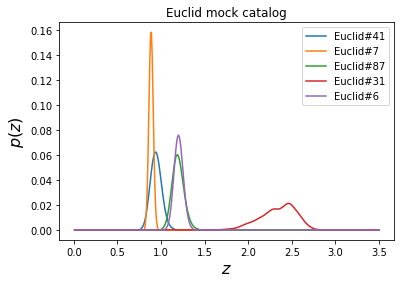

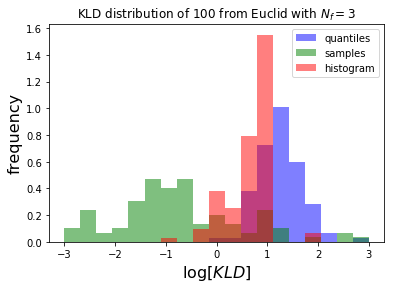

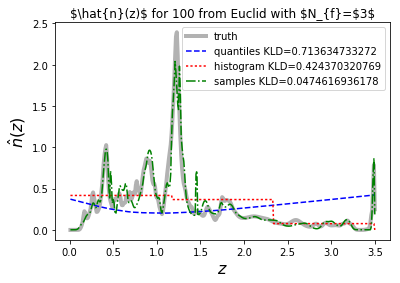

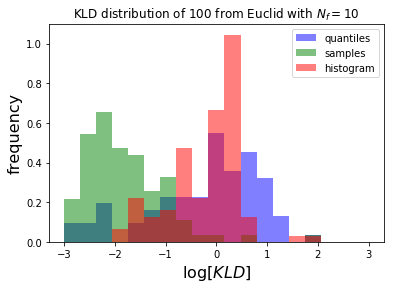

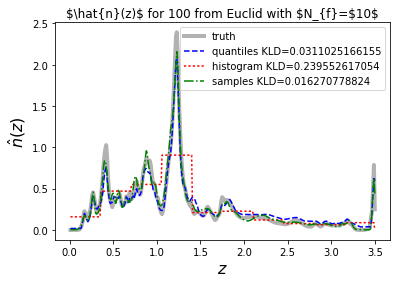

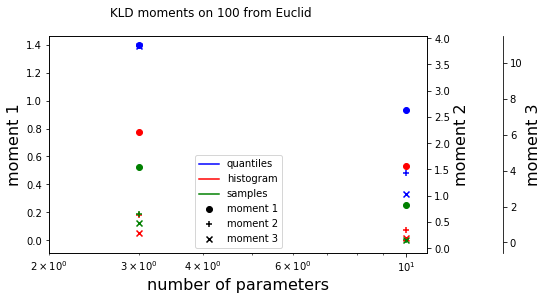

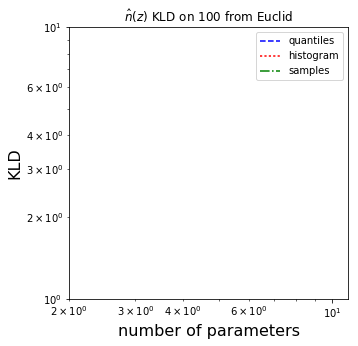

In [33]:
for name in names:
    for size in sizes:
        
        path = os.path.join(name, str(size))
        if not os.path.exists(path):
            os.makedirs(path)
        
        plot = plot_examples(size, name)
            
        for n_floats_use in floats:
            
            plot = plot_individual(size, name, n_floats_use)
            
            plot = plot_estimators(size, name, n_floats_use)
            
        plot = plot_pz_metrics(name, size)
        
        plot = plot_nz_metrics(name, size)